In [1]:
cd -q ~/research/Project_TaskSCCA/

In [3]:
import matplotlib.pyplot as plt

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from src.utils import unflatten, save_pkl, load_pkl, is_outliers, imputedata

from statsmodels.multivariate.manova import MANOVA
from scipy.stats import zscore

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style({"font.sans-serif": ["Arial"]})
sns.set_context('paper', font_scale=1.5)

In [4]:
from statsmodels.stats.multitest import multipletests

# Prepare data

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression

# def bootstrap_wrap(func, fit_reg niter=1000):
    

In [5]:
X_clean = np.load('data/processed/X_clean.npy')
Y_clean = np.load('data/processed/Y_clean.npy')
sig_mod = load_pkl('models/sig_95th.pkl')
model = load_pkl('models/full_model_95th.pkl')

path_master = 'data/interim/df_master_p178.pkl'
df_master = pd.read_pickle(path_master)

df_es = pd.read_pickle('./data/interim/CS_MWQ_prepro.pkl')

sig = sig_mod['sig']
X_scores, Y_scores = model.transform(X_clean, Y_clean)
X_scores, Y_scores = X_scores[:, sig], Y_scores[:, sig]
cca_df = pd.DataFrame({'Functional connectivity 1': X_scores[:, 0], 
                       'Functional connectivity 2': X_scores[:, 1],
                       'Cognitive task 1': Y_scores[:, 0], 
                       'Cognitive task 2': Y_scores[:, 1],})

df_cca = pd.DataFrame(zscore(X_scores) + zscore(Y_scores), 
                      columns=['component_1', 'component_2'], 
                      index=df_master.index)
df_es_pca = df_master.iloc[:, 18:30].infer_objects()

In [6]:
print(sig_mod['can_corr'])

[0.56570486 0.58651279]


In [7]:
print(sig_mod['p_val'])

[0.036 0.011]


In [8]:
df_es = pd.read_pickle('./data/interim/CS_MWQ_prepro.pkl').infer_objects()
df_es_mean = df_es.pivot_table(index=['RIDNO'],
                               values=df_es.columns[3:],
                               aggfunc=np.mean).apply(zscore)

In [9]:
df_es['nBack'].astype(str)
df_es_bytask = df_es.pivot_table(index=['RIDNO', 'nBack'],
                                 values=df_es.columns[3:],
                                 aggfunc=np.mean).apply(zscore)
df_es_bytask = df_es_bytask.unstack()

In [10]:
# USE THIS FOR STATS IN THE NOTEBOOK
df_stats = pd.concat([df_es_mean, df_es_bytask, df_cca], axis=1, join='inner')

In [11]:
np.min(df_master.AGE)

18.0

In [12]:
oneback = []
zeroback = []
new_col = []
for col in df_stats.columns[13: -2]:
    new_col.append(col[0] + '_' + str(int(col[1])))
    if float(col[1]) == 1:
        oneback.append(col[0] + '_' + str(int(col[1])))
    else:
        zeroback.append(col[0] + '_' + str(int(col[1])))

es = df_stats.columns[:13].tolist()
new_col = es + new_col + ['component_1', 'component_2']
df_stats.columns = new_col

In [13]:
es

['MWQ_Deliberate',
 'MWQ_Detailed',
 'MWQ_Emotion',
 'MWQ_Evolving',
 'MWQ_Focus',
 'MWQ_Future',
 'MWQ_Habit',
 'MWQ_Images',
 'MWQ_Other',
 'MWQ_Past',
 'MWQ_Self',
 'MWQ_Vivid',
 'MWQ_Words']

In [14]:
diff_labels = []
for e in es:
    diff_labels.append(e + '_diff')

df_diff = pd.DataFrame(df_stats[oneback].values - df_stats[zeroback].values, index=df_stats.index, columns=diff_labels)
df_stats = pd.concat([df_diff, df_stats], axis=1, join='inner')

In [14]:
def MANOVA_with_fig(endog_labels, filename):
    manova = MANOVA(endog=df_stats[endog_labels],
                exog=df_stats[['component_1', 'component_2']] )
    
    print(manova.mv_test())
    results = manova.mv_test().results
    sig_key = []

    for key, (_, output) in zip(manova.mv_test().exog_names, results.items()):
        p_val = output['stat']['Pr > F'][0]
        key = (' ').join(key.split('_'))
        if  p_val < 0.05:
            sig_key.append((key, p_val))
        # partial eta square
        f_val = output['stat']['F Value'][0]
        den_df = output['stat']['Den DF'][0]
        num_df = output['stat']['Num DF'][0]
        par_eta_sqr = num_df * f_val / (num_df *f_val + den_df)
        print('partical eta squared of {}: {}'.format(key, par_eta_sqr))

            
    if len(sig_key) == 0:
        sig_key.append(('None', 'N/A'))
    
    df_coef = pd.DataFrame()
    df_pval = pd.DataFrame()

    for q in endog_labels:
        univeriate = smf.ols(formula='{} ~ component_1 + component_2'.format(q), data=df_stats).fit()
        print(univeriate.summary())
        p_adjust = multipletests(univeriate.pvalues, alpha=0.05, method='bonferroni')
        df_coef = df_coef.append(univeriate.params, ignore_index=True)
        df_p_adjust = pd.DataFrame(np.array([p_adjust[0],
                                             p_adjust[1]]).T, 
                                   index=['Intercept', '1', '2'],
                                   columns=['Sig.', 'p_adjusted']
                                  )
        df_pval = df_pval.append(df_p_adjust.iloc[:, 1], ignore_index=True)
        print(df_p_adjust)
        print('Bonferroni corrected alpha (0.05): {}\n'.format(
            multipletests(univeriate.pvalues, alpha=0.05, method='bonferroni')[-1]))
    
    df_coef.index = [a.split('_')[-1] for a in es]
    df_pval.index = df_coef.index

    df_coef.columns = ['Intercept', '1', '2']


    sns.heatmap(df_coef.iloc[:, 1:], cmap="PiYG_r", square=False, center=0, annot=df_pval.iloc[:, :-1])
    plt.title('Full univariate results')
    plt.annotate('''
    * Value in each cell is Bonferroni corrected p-value.
    ** {:} is significant at multivatiate level.
       p = {:}'''.format(sig_key[0][0], sig_key[0][1]), 
                 (0,0), (0, -30), 
                 xycoords='axes fraction', 
                 textcoords='offset points', va='top')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, transparent=True)
    return df_coef

# Predict thoguhts with CCA components

When using the two CCA scores to predict the expereince sampling questions scores, component 2 is significant in all the mutivariate models of all the questions, 0-back or 1-back questions. The difference score of 0-back and 1-back, however, didn't show significant relationships in the Multivariate Multiple Regression. See bellow to find the detailed MANOVA tables and the correlation coefficients and Bonferroni adjusted p-values of the univariate model in heat map format.

When predicting PCA scores, there's no significant results at the multivariate level.

## MANOVA: average experience sampling scores

                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9518 13.0000 164.0000  0.6390 0.8186
         Pillai's trace 0.0482 13.0000 164.0000  0.6390 0.8186
 Hotelling-Lawley trace 0.0506 13.0000 164.0000  0.6390 0.8186
    Roy's greatest root 0.0506 13.0000 164.0000  0.6390 0.8186
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8147 13.0000 164.0000  2.8694 0.0009
         Pillai's trace 0.1853 13.0000 164.0000  2.8694 0.0009
 Hotelling-

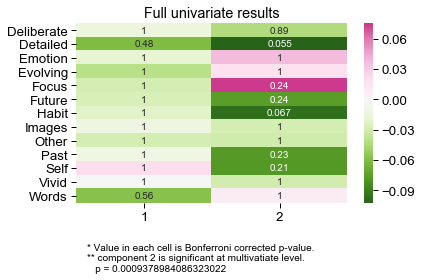

In [15]:
df_es_coef = MANOVA_with_fig(es, './reports/figures/_univariate_es.png')

## MANOVA: average 0-back experience sampling scores

                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9539 13.0000 164.0000  0.6095 0.8440
         Pillai's trace 0.0461 13.0000 164.0000  0.6095 0.8440
 Hotelling-Lawley trace 0.0483 13.0000 164.0000  0.6095 0.8440
    Roy's greatest root 0.0483 13.0000 164.0000  0.6095 0.8440
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8380 13.0000 164.0000  2.4389 0.0048
         Pillai's trace 0.1620 13.0000 164.0000  2.4389 0.0048
 Hotelling-

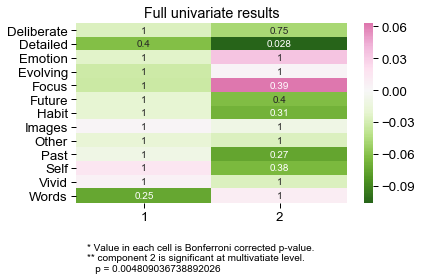

In [16]:
df_0b_coef = MANOVA_with_fig(zeroback, './reports/figures/univariate_es_0back.png')

## MANOVA: average 1-back experience sampling scores

                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9561 13.0000 164.0000  0.5787 0.8687
         Pillai's trace 0.0439 13.0000 164.0000  0.5787 0.8687
 Hotelling-Lawley trace 0.0459 13.0000 164.0000  0.5787 0.8687
    Roy's greatest root 0.0459 13.0000 164.0000  0.5787 0.8687
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8095 13.0000 164.0000  2.9688 0.0006
         Pillai's trace 0.1905 13.0000 164.0000  2.9688 0.0006
 Hotelling-

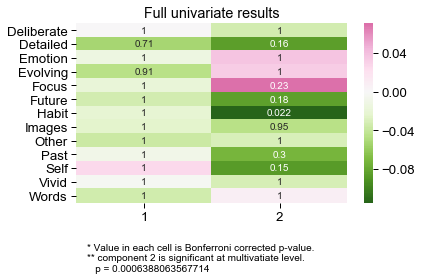

In [17]:
df_1b_coef = MANOVA_with_fig(oneback, './reports/figures/univariate_es_1back.png')

## MANOVA: differeces between average experience sampling scores in 1- and 0-back

                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9724 13.0000 164.0000  0.3583 0.9804
         Pillai's trace 0.0276 13.0000 164.0000  0.3583 0.9804
 Hotelling-Lawley trace 0.0284 13.0000 164.0000  0.3583 0.9804
    Roy's greatest root 0.0284 13.0000 164.0000  0.3583 0.9804
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9251 13.0000 164.0000  1.0215 0.4331
         Pillai's trace 0.0749 13.0000 164.0000  1.0215 0.4331
 Hotelling-

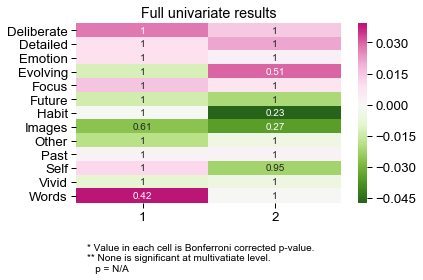

In [18]:
df_diff_coef = MANOVA_with_fig(diff_labels, './reports/figures/univariate_es_difftask.png')

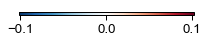

In [19]:
import matplotlib.colors as mcolor
import matplotlib.colorbar as mcb
import matplotlib.cm as mcm

df = df_es_coef
# create colorbar and color
pv_in_hex= []
vmax = np.abs(df.values).max()
vmin = -vmax
for i in range(df.values.shape[1]):
    rescale = (df.values[:,i] - vmin) / (vmax - vmin)
    colors_hex = []
    for c in mcm.RdBu_r(rescale):
        colors_hex.append(mcolor.to_hex(c))
    pv_in_hex.append(colors_hex)
colors_hex = np.array(pv_in_hex).T
df_color = pd.DataFrame(colors_hex, columns=df.columns, index=df.index)

fig = plt.figure(figsize=(3, 0.7))
ax = fig.add_subplot(111)
cmap = mcm.RdBu_r
norm = mcolor.Normalize(vmin=vmin, vmax=vmax)
cb1 = mcb.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
plt.tight_layout()
plt.savefig('reports/figures/univariate_es_wordcloud_cb.png', transparent=True, dpi=300)

In [20]:
df = pd.concat([df_es_coef['2'], df_color['2']], axis=1)
df.reset_index(level=0, inplace=True)
df.columns = ['word', 'ori_weight', 'color']
df['weight'] = np.round(np.abs(df['ori_weight'] * 100))
df = df[['weight', 'word', 'color']]
df.to_csv('reports/figures/univariate_es_wordcloud.csv')

In [21]:
df = pd.concat([df_1b_coef['2'], df_color['2']], axis=1)
df.reset_index(level=0, inplace=True)
df.columns = ['word', 'ori_weight', 'color']
df['weight'] = np.round(np.abs(df['ori_weight'] * 100))
df = df[['weight', 'word', 'color']]
df.to_csv('reports/figures/stats_wordclouds/univariate_es_1back_wordcloud.csv')

In [27]:
from scipy.stats import pearsonr

print(pearsonr(df_es_coef['2'], df_1b_coef['2']))
print(pearsonr(df_es_coef['2'], df_0b_coef['2']))
print(pearsonr(df_1b_coef['2'], df_0b_coef['2']))


(0.9817328798133717, 2.825399554174895e-09)
(0.9800567016760748, 4.564377836957583e-09)
(0.9251712085365967, 5.910819725664208e-06)


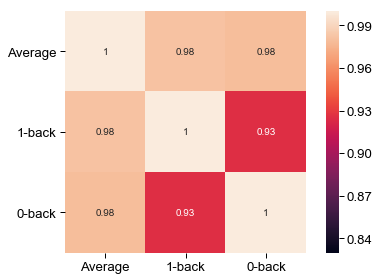

In [24]:
corr_pattern = np.corrcoef([df_es_coef['2'], df_1b_coef['2'], df_0b_coef['2']])
df_cor = pd.DataFrame(corr_pattern,
                      columns=['Average', '1-back', '0-back'],
                      index=['Average', '1-back', '0-back'])

plt.figure()
sns.heatmap(df_cor, square=True, vmin=0.83, annot=df_cor)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig('reports/figures/stats_wordclouds/pattern_corr_by_task.png', dpi=300, transparent=True)

## For cortical thickness

In [13]:
df_stats.to_csv('reports/HW_cohort_taskCCA.csv')

In [18]:
df_js = pd.concat([df_master.iloc[:, :-int(99*50)], df_cca, df_es_mean, df_es_bytask], 
                  join='inner', axis=1)
df_js.to_csv('reports/HW_cohort_taskCCA_full.csv')

In [14]:
cca_df.index = df_master.index
df_demo = df_master.loc[:, ['AGE', 'GENDER']]

df_NH = pd.concat([cca_df, df_demo], axis=1, join='inner')

# preprocess RSES
raw = df_NH.values[:, :-1].astype(float)
# find outliers and replace with nan
mean = np.nanmean(raw, axis=0)
median = np.nanmedian(raw, axis=0)

data_sign = np.sign(raw - mean)
data_sign[np.isnan(data_sign)] = 0 # missing data will be imputed as mean or median
is_out = is_outliers(raw)
raw[is_out] = np.nan

# replace nan with median
for i in range(raw.shape[1]):
    ind_nan = np.where(np.isnan(raw[:, i]))
    raw[ind_nan, i] = median[i]
# zscore    
z = zscore(raw)

df_RS = pd.DataFrame(z, columns=df_NH.columns[:-1], index=df_NH.index)
df_demo = df_master.loc[:, 'GENDER']

df_NH = pd.concat([df_RS, df_demo], axis=1, join='inner')
df_NH.to_csv('./data/processed/CS_CCA_scores.csv')